In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from IPython.display import display, Markdown

import warnings
warnings.filterwarnings("ignore")



pd.set_option('display.float_format', '{:.4f}'.format)

# Funciones

In [14]:
"""
Calcular precio de una opción de compra y venta usando el modelo de Black-Scholes.
-------------------------------------------------------------------------------------------------------------
"""
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


"""
Simulación de Monte Carlo para opciones de compra y venta.
--------------------------------------------------------------------------------------------------------------
"""
def monte_carlo_antithetic(S0, mu, sigma, T, num_simulations, num_steps):
    actual_sims = num_simulations // 2
    dt = T/num_steps
    price_paths = np.zeros((num_simulations, num_steps+1))
    price_paths[:,0] = S0
    
    for i in range(actual_sims):
        for j in range(1, num_steps+1):
            z = np.random.normal(0, 1)
            price_paths[i,j] = price_paths[i,j-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
            price_paths[i+actual_sims,j] = price_paths[i+actual_sims,j-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * (-z))
    return price_paths


"""
Plot de simulación de Monte Carlo del precio de una acción.
--------------------------------------------------------------------------------------------------------------
"""
def plot_caminos(num_simulations, sim_month, sim_quarter, sim_year, ticker, closes):
    plt.figure(figsize=(15, 15))

    n_closes = len(closes)
    start_idx = int(n_closes * 0.8)
    truncated_closes = closes.iloc[start_idx:] if isinstance(closes, pd.Series) else closes[start_idx:]
    
    x_historical = np.arange(len(truncated_closes))
    x_sim_month = np.arange(len(truncated_closes), len(truncated_closes) + len(sim_month[0]))
    x_sim_quarter = np.arange(len(truncated_closes), len(truncated_closes) + len(sim_quarter[0]))
    x_sim_year = np.arange(len(truncated_closes), len(truncated_closes) + len(sim_year[0]))

    plt.subplot(3, 1, 1)
    plt.plot(x_historical, truncated_closes, color='darkslategray', label='Último 20% histórico')
    for i in range(num_simulations):
        plt.plot(x_sim_month, sim_month[i], color='darkslategray', lw=1, alpha=0.15)
    plt.title(f'Simulaciones {ticker.upper()} | 1 mes ({num_simulations} caminos)', fontsize=16, fontweight='bold')
    plt.ylabel('Precio')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(x_historical, truncated_closes, color='darkslategray', label='Último 20% histórico')
    for i in range(num_simulations):
        plt.plot(x_sim_quarter, sim_quarter[i], color='darkslategray', lw=1, alpha=0.15)
    plt.title(f'Simulaciones {ticker.upper()} | 3 meses ({num_simulations} caminos)', fontsize=16, fontweight='bold')
    plt.ylabel('Precio')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(x_historical, truncated_closes, color='darkslategray', label='Último 20% histórico')
    for i in range(num_simulations):
        plt.plot(x_sim_year, sim_year[i], color='darkslategray', lw=1, alpha=0.15)
    plt.title(f'Simulaciones {ticker.upper()} | 1 año ({num_simulations} caminos)', fontsize=16, fontweight='bold')
    plt.ylabel('Precio')
    plt.xlabel('Días desde inicio del período mostrado')
    plt.legend()

    plt.tight_layout()
    plt.show()

"""
Simulación de un collar con variables antitéticas.
--------------------------------------------------------------------------------------------------------------
"""
def create_collar_antithetic(S, T, r, sigma, num_simulations, num_steps):
    S = float(S.iloc[0]) if hasattr(S, 'iloc') else float(S)
    put_strike = S * 0.95
    call_strike = S * 1.05
    
    put_premium = float(black_scholes_put(S, put_strike, T, r, sigma))
    call_premium = float(black_scholes_call(S, call_strike, T, r, sigma))
    net_cost = call_premium - put_premium

    markdown_text = f"""
### *Estrategia Collar (Antitético) | {float(T)*12:.0f} meses.*

| Parámetro           | Valor               |
|---------------------|---------------------|
| **Precio Actual (S)** | ${float(S):.2f}           |
| **Tiempo (T)**      | {float(T)*12:.1f} meses    |
| **Volatilidad (σ)** | {float(sigma)*100:.1f}%    |
| **Tasa libre (r)**  | {float(r)*100:.1f}%        |

**Componentes del Collar:**

- **Put (Protección)**  
  - Strike (95% S): `${float(put_strike):.2f}`  
  - Prima: `${float(put_premium):.2f}` *(costo)*  

- **Call (Límite)**  
  - Strike (105% S): `${float(call_strike):.2f}`  
  - Prima: `${float(call_premium):.2f}` *(ingreso)*  

**Neto del Collar:** `${float(net_cost):.2f}`  
"""
    display(Markdown(markdown_text))

    paths = monte_carlo_antithetic(S, r, sigma, T, num_simulations, num_steps)
    final_prices = paths[:, -1]
    
    stock_payoff = final_prices - S
    put_payoff = np.maximum(put_strike - final_prices, 0) - put_premium
    call_payoff = call_premium - np.maximum(final_prices - call_strike, 0)
    total_payoff = stock_payoff + put_payoff + call_payoff
    
    return final_prices, total_payoff, put_strike, call_strike, call_payoff, put_payoff


"""
Plot del payoff del collar con variables antitéticas.
--------------------------------------------------------------------------------------------------------------
"""
def plot_collar_payoff(final_prices, payoff, put_strike, call_strike, S, horizon, call_payoff, put_payoff, ticker):
    sorted_indices = np.argsort(final_prices)
    sorted_prices = final_prices[sorted_indices]
    sorted_payoff = payoff[sorted_indices]
    sorted_call_payoff = call_payoff[sorted_indices]
    sorted_put_payoff = put_payoff[sorted_indices]
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(sorted_prices, sorted_payoff, label='Payoff del Collar', color='red', linewidth=2, zorder=3)
    
    plt.plot(sorted_prices, sorted_put_payoff, label='Payoff Long Put', color='steelblue', linestyle='--',linewidth=1.5, zorder=2)
    plt.plot(sorted_prices, sorted_call_payoff, label='Payoff Short Call', color='goldenrod', linestyle='--',linewidth=1.5, zorder=2)
    
    plt.axvline(x=put_strike, color='cadetblue', linestyle='--',linewidth=1.5, label='Strike Long Put (95%)', zorder=1)
    plt.axvline(x=call_strike, color='darkorange', linestyle='--',linewidth=1.5, label='Strike Short Call (105%)', zorder=1)
    plt.axvline(x=S, color='k', linestyle=':', label='Precio Actual', zorder=1)
    plt.axhline(y=0, color='k', linestyle='-', linewidth=1.5, zorder=2)
    
    plt.title(f'Payoff del Collar Hedge {ticker.upper()} | Horizonte de {horizon}', fontsize=16, fontweight='bold')
    plt.xlabel('Precio Final de la Acción')
    plt.ylabel('P&L del Collar')
    plt.grid(alpha=0.4, ls='--', lw=0.5)

    prob_profit = np.mean(payoff > 0) * 100
    mean_payoff = np.mean(payoff)
    ci_lower = np.percentile(payoff, 2.5)
    ci_upper = np.percentile(payoff, 97.5)

    plt.fill_between(sorted_prices, sorted_payoff, where=(sorted_payoff > 0), color='green', alpha=0.3, label='Ganancia')
    plt.fill_between(sorted_prices, sorted_payoff, where=(sorted_payoff < 0), color='indianred', alpha=0.3, label='Pérdida')
    
    plt.legend(loc='lower right')

    texto = (
        f"Strike Short Call: ${call_strike:.2f}\n"
        f"Strike Long Put: ${put_strike:.2f}\n"
        f"P&L Esperado: ${mean_payoff:.2f}\n"
        f"Intervalo Confianza 95%: {ci_lower:.2f} < P&L < {ci_upper:.2f}\n"
        f"Prob. Ganancia: {prob_profit:.1f}%"
    )

    bbox_props = dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="lightgray", alpha=0.9)
    plt.text(0.018, 0.03, texto, transform=plt.gca().transAxes, fontsize=11, bbox=bbox_props, verticalalignment='bottom', horizontalalignment='left')

    plt.show()


"""
Ejecutar el código para un activo x
--------------------------------------------------------------------------------------------------------------
"""
def execute(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)['Close']
    rt = data.pct_change().dropna()

    current_price = data.iloc[-1].iloc[0]
    r = 0.0425
    sigma = rt.std() * np.sqrt(252)
    mu = rt.mean() * 252 

    markdown_text = f"""
# {ticker.upper()}

## **Resumen del activo**

Entrenamiento desde {start_date} hasta {end_date}.

| Parámetro           | Valor               |
|---------------------|---------------------|
| **Precio Actual** | ${float(current_price):.2f}           |
| **Volatilidad** | {sigma.iloc[0]*100:.2f}%    |
| **Rendimiento esperado**  | {mu.iloc[0]*100:.2f}%        |
"""
    display(Markdown(markdown_text))

    num_simulations = 200  
    num_steps_month = 21  
    num_steps_quarter = 63  
    num_steps_year = 252  

    sim_month = monte_carlo_antithetic(current_price, mu, sigma, 1/12, num_simulations, num_steps_month)
    sim_quarter = monte_carlo_antithetic(current_price, mu, sigma, 0.25, num_simulations, num_steps_quarter)
    sim_year = monte_carlo_antithetic(current_price, mu, sigma, 1, num_simulations, num_steps_year)

    display(Markdown(f"## **Simulaciones de Monte Carlo para {ticker.upper()}**"))
    plot_caminos(num_simulations, sim_month, sim_quarter, sim_year, ticker, data)

    display(Markdown(f"## **Collar Hedge para {ticker.upper()} a diferentes horizontes temporales**"))
    final_prices_month, payoff_month, put_strike_month, call_strike_month, call_payoff_month, put_payoff_month = create_collar_antithetic(current_price, 1/12, r, sigma, num_simulations, num_steps_month)
    plot_collar_payoff(final_prices_month, payoff_month, put_strike_month, call_strike_month, current_price, "1 mes", call_payoff_month, put_payoff_month, ticker)

    final_prices_quarter, payoff_quarter, put_strike_quarter, call_strike_quarter, call_payoff_quarter, put_payoff_quarter = create_collar_antithetic(current_price, 0.25, r, sigma, num_simulations, num_steps_quarter)
    plot_collar_payoff(final_prices_quarter, payoff_quarter, put_strike_quarter, call_strike_quarter, current_price, "3 meses", call_payoff_quarter, put_payoff_quarter, ticker)

    final_prices_year, payoff_year, put_strike_year, call_strike_year, call_payoff_year, put_payoff_year = create_collar_antithetic(current_price, 1, r, sigma, num_simulations, num_steps_year)
    plot_collar_payoff(final_prices_year, payoff_year, put_strike_year, call_strike_year, current_price, "1 año", call_payoff_year, put_payoff_year, ticker)

    display(Markdown(f"---"))
    display(Markdown(f"---"))
    display(Markdown(f"---"))


# PG

## **Resumen del activo**

Entrenamiento desde 2023-01-01 hasta 2025-05-01.

| Parámetro           | Valor               |
|---------------------|---------------------|
| **Precio Actual** | $162.57           |
| **Volatilidad** | 16.50%    |
| **Rendimiento esperado**  | 7.08%        |


## **Simulaciones de Monte Carlo para PG**

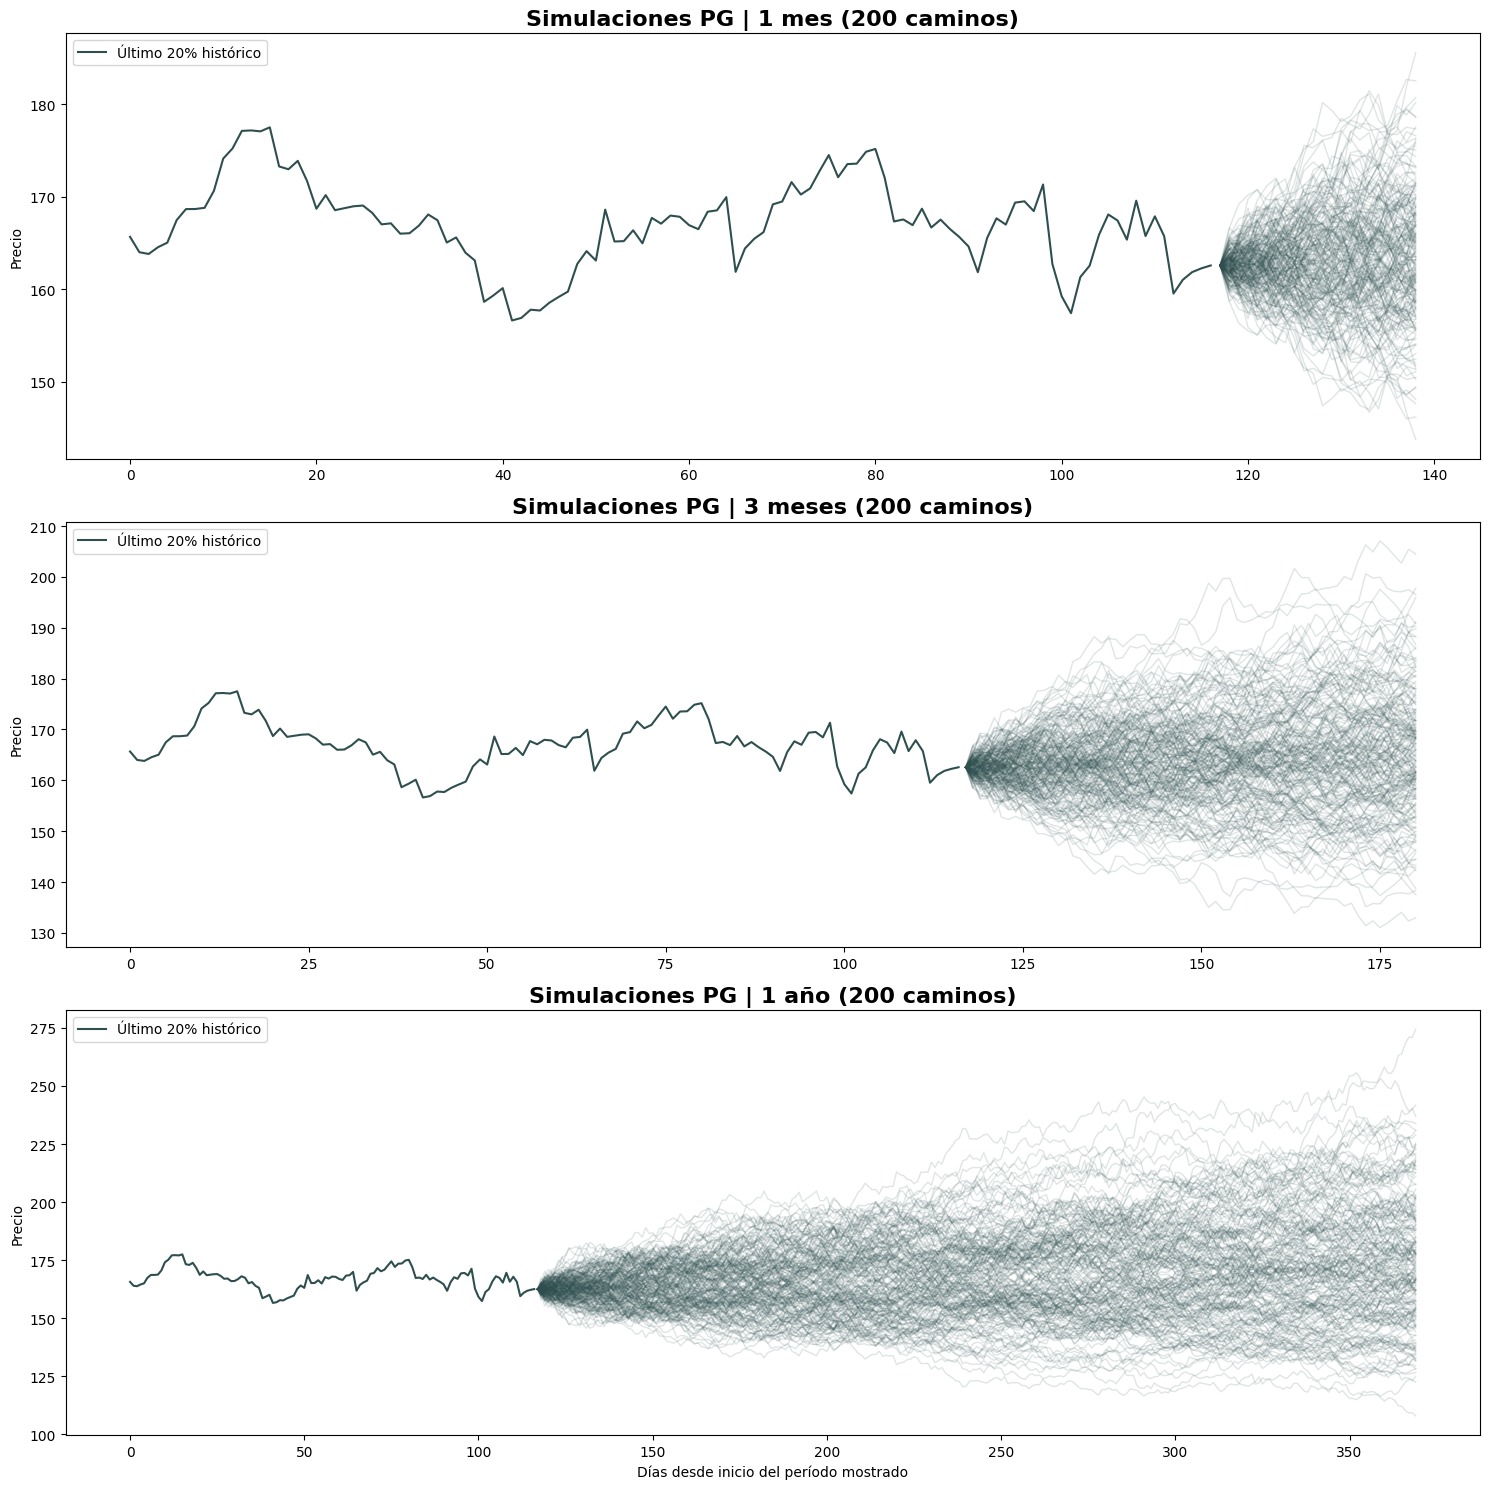

## **Collar Hedge para PG a diferentes horizontes temporales**


### *Estrategia Collar (Antitético) | 1 meses.*

| Parámetro           | Valor               |
|---------------------|---------------------|
| **Precio Actual (S)** | $162.57           |
| **Tiempo (T)**      | 1.0 meses    |
| **Volatilidad (σ)** | 16.5%    |
| **Tasa libre (r)**  | 4.2%        |

**Componentes del Collar:**

- **Put (Protección)**  
  - Strike (95% S): `$154.44`  
  - Prima: `$0.47` *(costo)*  

- **Call (Límite)**  
  - Strike (105% S): `$170.70`  
  - Prima: `$0.73` *(ingreso)*  

**Neto del Collar:** `$0.26`  


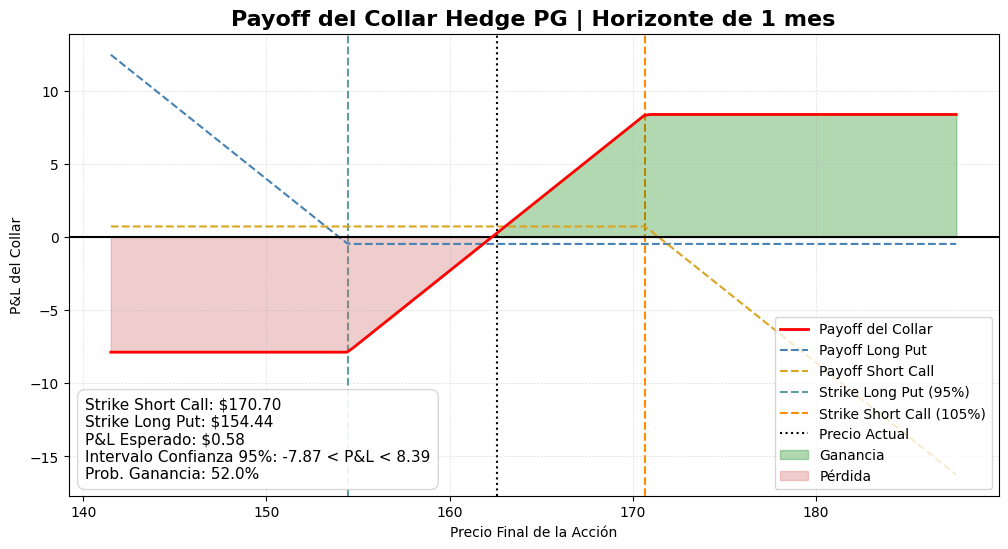


### *Estrategia Collar (Antitético) | 3 meses.*

| Parámetro           | Valor               |
|---------------------|---------------------|
| **Precio Actual (S)** | $162.57           |
| **Tiempo (T)**      | 3.0 meses    |
| **Volatilidad (σ)** | 16.5%    |
| **Tasa libre (r)**  | 4.2%        |

**Componentes del Collar:**

- **Put (Protección)**  
  - Strike (95% S): `$154.44`  
  - Prima: `$1.70` *(costo)*  

- **Call (Límite)**  
  - Strike (105% S): `$170.70`  
  - Prima: `$2.86` *(ingreso)*  

**Neto del Collar:** `$1.16`  


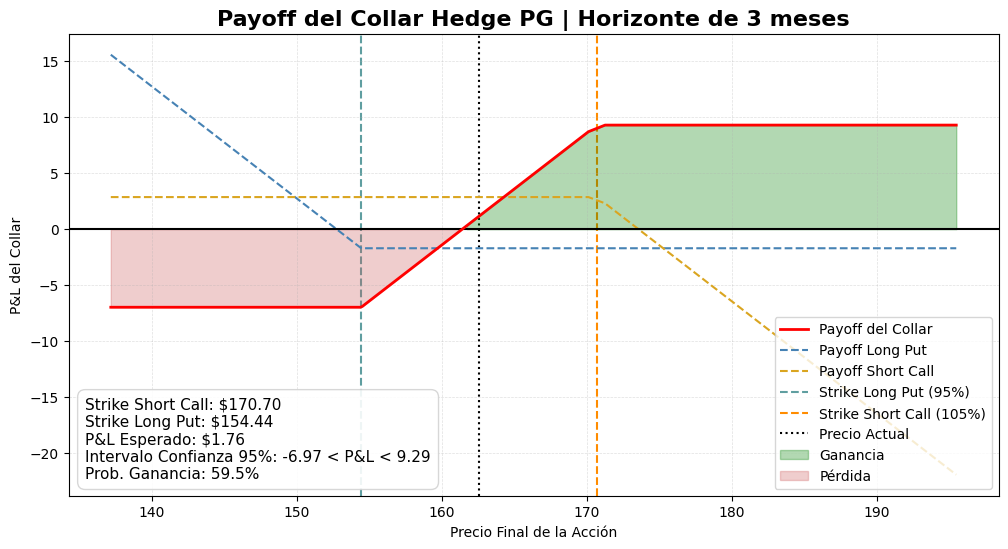


### *Estrategia Collar (Antitético) | 12 meses.*

| Parámetro           | Valor               |
|---------------------|---------------------|
| **Precio Actual (S)** | $162.57           |
| **Tiempo (T)**      | 12.0 meses    |
| **Volatilidad (σ)** | 16.5%    |
| **Tasa libre (r)**  | 4.2%        |

**Componentes del Collar:**

- **Put (Protección)**  
  - Strike (95% S): `$154.44`  
  - Prima: `$4.53` *(costo)*  

- **Call (Límite)**  
  - Strike (105% S): `$170.70`  
  - Prima: `$10.22` *(ingreso)*  

**Neto del Collar:** `$5.68`  


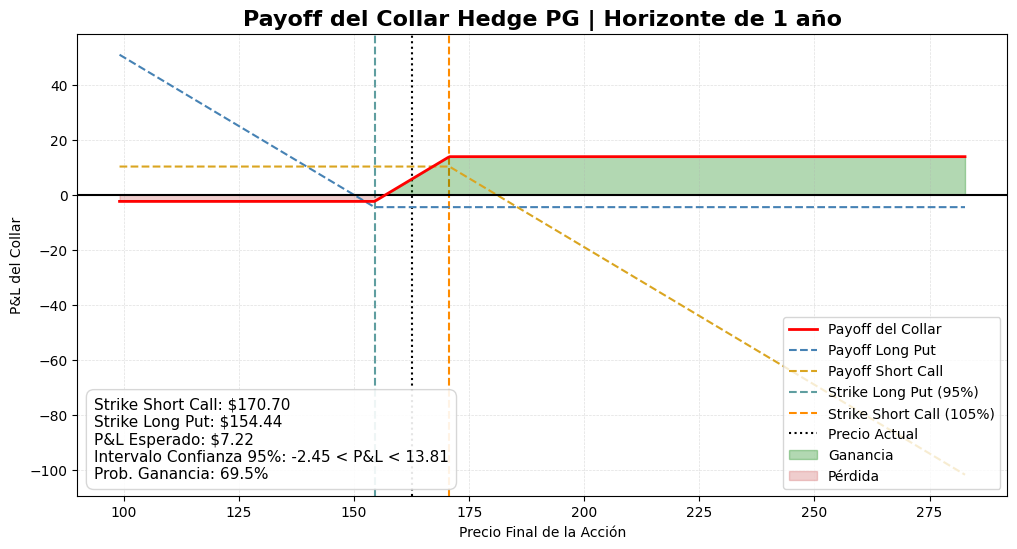

---

---

---


# V

## **Resumen del activo**

Entrenamiento desde 2023-01-01 hasta 2025-05-01.

| Parámetro           | Valor               |
|---------------------|---------------------|
| **Precio Actual** | $345.50           |
| **Volatilidad** | 18.31%    |
| **Rendimiento esperado**  | 24.53%        |


## **Simulaciones de Monte Carlo para V**

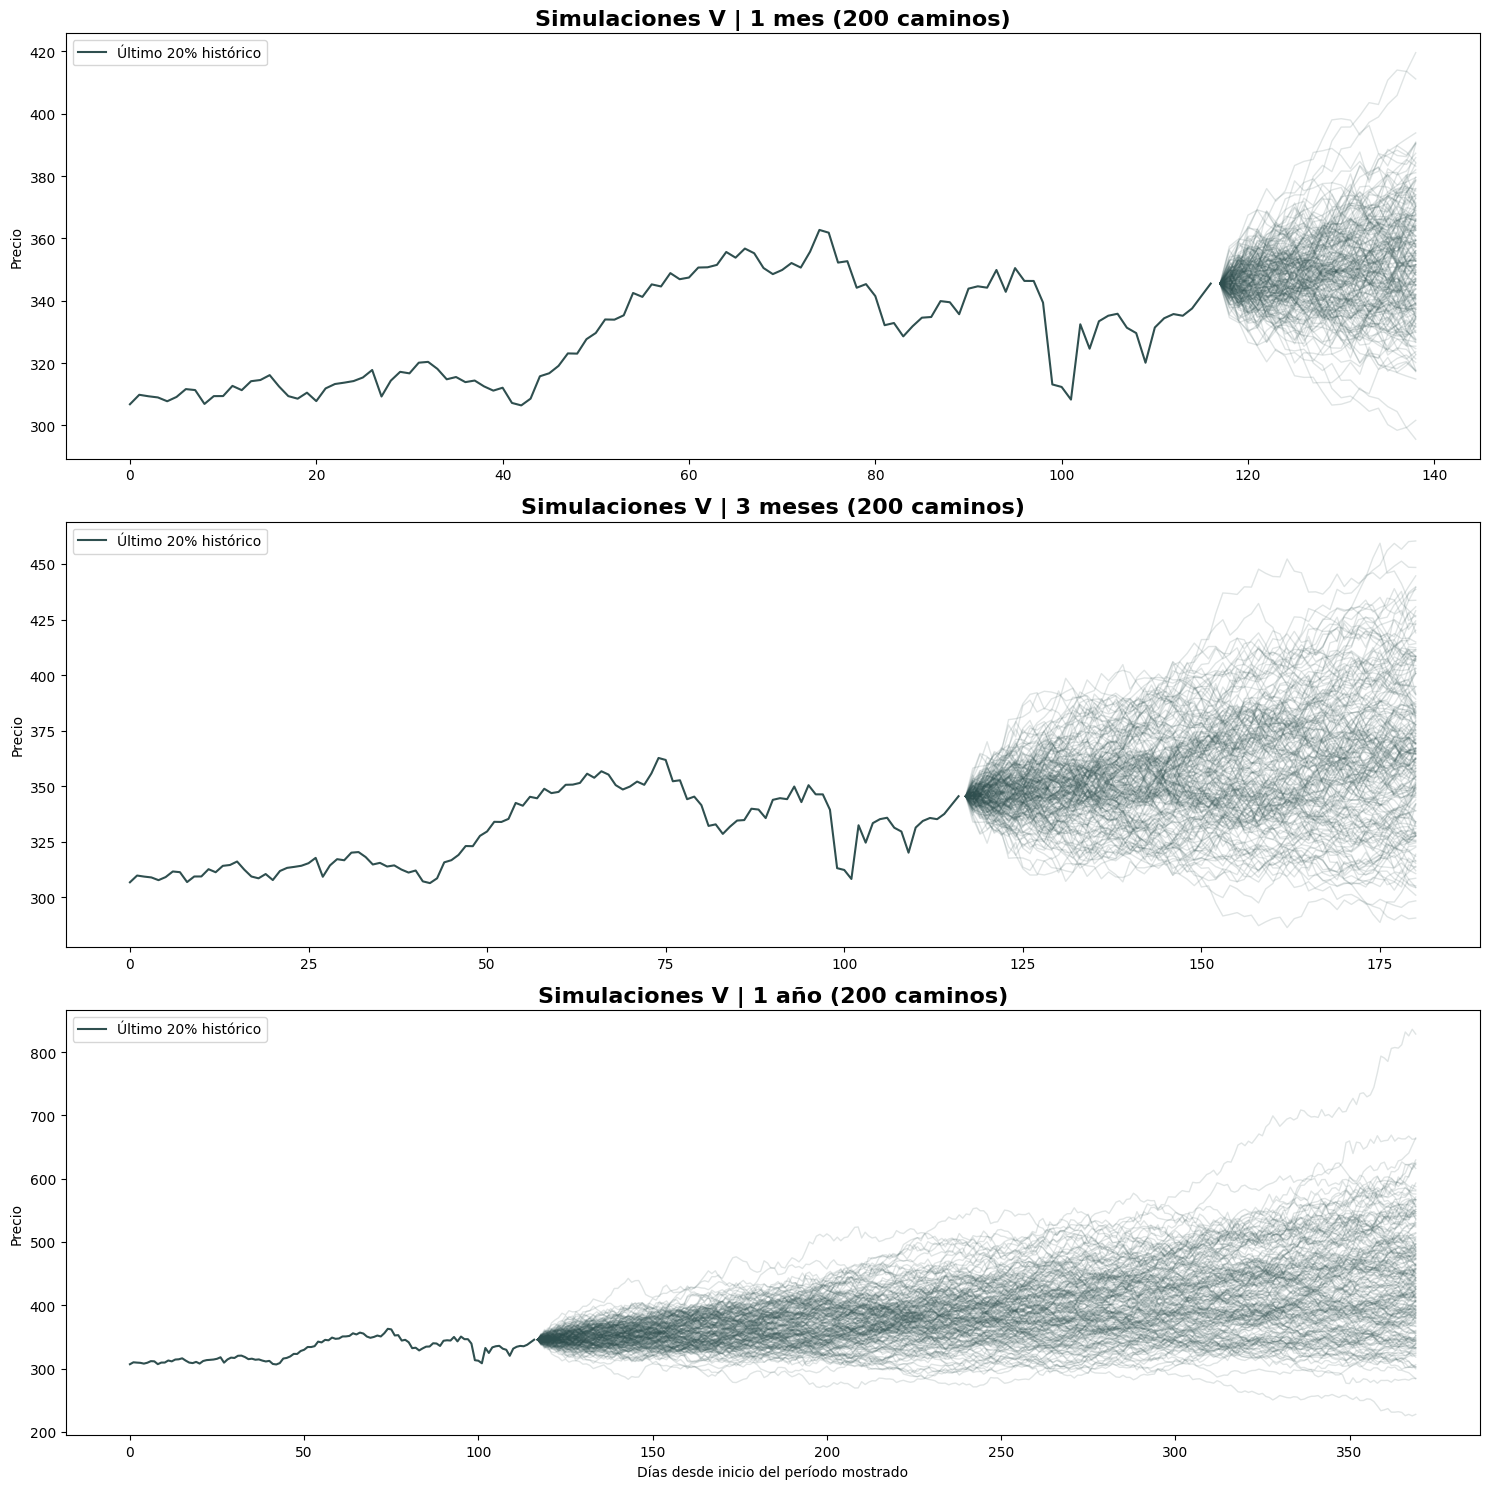

## **Collar Hedge para V a diferentes horizontes temporales**


### *Estrategia Collar (Antitético) | 1 meses.*

| Parámetro           | Valor               |
|---------------------|---------------------|
| **Precio Actual (S)** | $345.50           |
| **Tiempo (T)**      | 1.0 meses    |
| **Volatilidad (σ)** | 18.3%    |
| **Tasa libre (r)**  | 4.2%        |

**Componentes del Collar:**

- **Put (Protección)**  
  - Strike (95% S): `$328.22`  
  - Prima: `$1.38` *(costo)*  

- **Call (Límite)**  
  - Strike (105% S): `$362.78`  
  - Prima: `$2.03` *(ingreso)*  

**Neto del Collar:** `$0.65`  


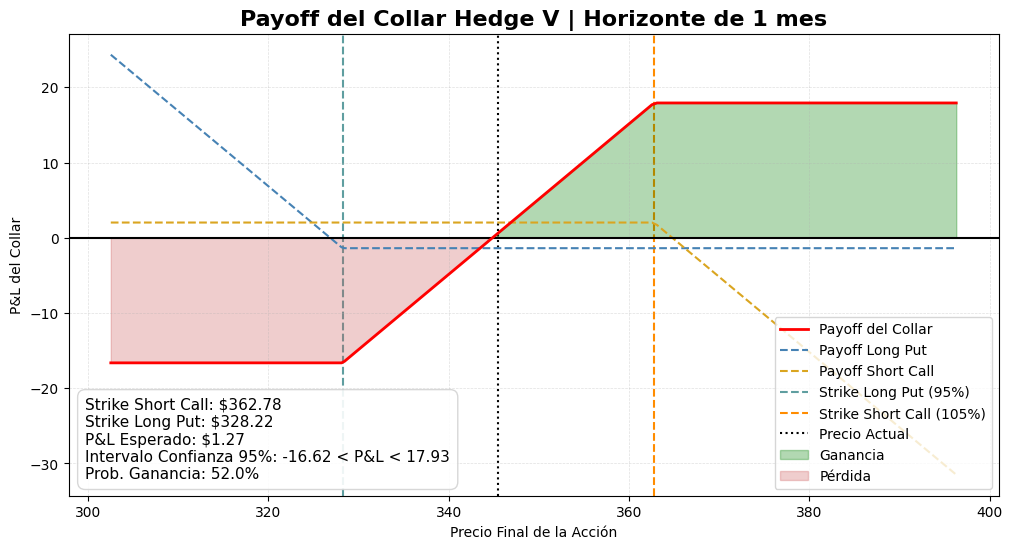


### *Estrategia Collar (Antitético) | 3 meses.*

| Parámetro           | Valor               |
|---------------------|---------------------|
| **Precio Actual (S)** | $345.50           |
| **Tiempo (T)**      | 3.0 meses    |
| **Volatilidad (σ)** | 18.3%    |
| **Tasa libre (r)**  | 4.2%        |

**Componentes del Collar:**

- **Put (Protección)**  
  - Strike (95% S): `$328.22`  
  - Prima: `$4.56` *(costo)*  

- **Call (Límite)**  
  - Strike (105% S): `$362.78`  
  - Prima: `$7.24` *(ingreso)*  

**Neto del Collar:** `$2.68`  


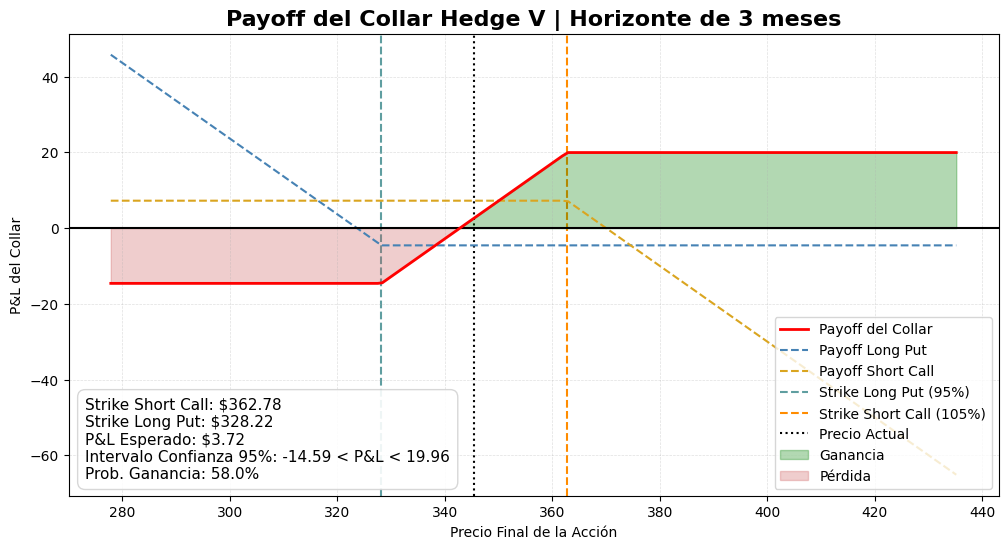


### *Estrategia Collar (Antitético) | 12 meses.*

| Parámetro           | Valor               |
|---------------------|---------------------|
| **Precio Actual (S)** | $345.50           |
| **Tiempo (T)**      | 12.0 meses    |
| **Volatilidad (σ)** | 18.3%    |
| **Tasa libre (r)**  | 4.2%        |

**Componentes del Collar:**

- **Put (Protección)**  
  - Strike (95% S): `$328.22`  
  - Prima: `$11.69` *(costo)*  

- **Call (Límite)**  
  - Strike (105% S): `$362.78`  
  - Prima: `$24.21` *(ingreso)*  

**Neto del Collar:** `$12.52`  


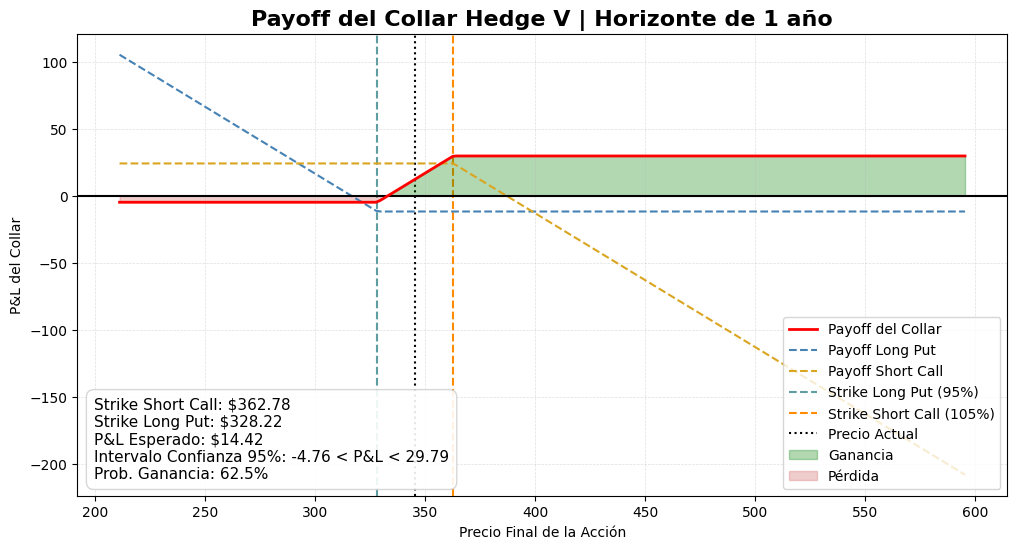

---

---

---

In [15]:
tickers = ['PG', 'V']
start_date = '2023-01-01'
end_date = '2025-05-01'

# for ticker in tickers:
for ticker in tickers:
    execute(ticker, start_date, end_date)